# Survival Analysis in Python

Changes in survival curves for non-Hodgkin lymphoma

Allen B. Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [57]:
import pandas as pd
import numpy as np

In [58]:
df = pd.read_hdf('nhl.hdf5', 'nhl')

[Case counts](https://seer.cancer.gov/manuals/textdata.cd1975_2016.counts.pdf)

In [59]:
df.shape

(33791, 6)

[Codebook](https://seer.cancer.gov/data-software/documentation/seerstat/nov2018/TextData.FileDescription.pdf)

SEX
1 Male
2 Female

AGE_DX: age at diagnosis
999 unknown

YEAR_DX: year of diagnosis

PRIMSITE: primary site
>This data item identifies the site in which the primary tumor originated.  See the International Classification of Diseases for Oncology, Third Edition (ICD-O-3) for topography codes.  The decimal point is eliminated.   Cases diagnosed 1977-1991 were coded using the International Classification of Diseases for Oncology, 1976 Edition (ICD-O-1976).  Prior to 1977 diagnoses, cases were coded using the Manual of Tumor Nomenclature and Coding, 1968 (MOTNAC).  All cases 1975-1991 were machine-converted to ICD-O-2 codes without complete hand review.

HISTOLOGY: 

GRADE:
>Grading and differentiation codes of 1-4, 9 are defined in ICD-O-2; 1992.  Grade information may be incomplete for cases diagnosed before 1977.In the before 1980’s, additional codes specifying T-cell, B-cell, or null cell involvement in lymphomas and leukemias (histologies M9590-9940) were introduced by SEER.  Because the reporting requirements and medical terminology have changed over time, care should be exercised when analyzing this information.

```
1 Grade I; grade i; grade 1; well differentiated; differentiated, NOS
2 Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation
3 Grade III; grade iii; grade 3; poorly differentiated; differentiated
4 Grade IV; grade iv; grade 4; undifferentiated; anaplastic
5 T-cell; T-precursor
6 B-cell; Pre-B; B-Precursor
7 Null cell; Non T-non B;
8 N K cell (naturalkiller cell)
9 cell type not determined, not stated or not applicable
```

HISTREC:

Histology recode - broad groupings based on Histologic Type ICD-O-3

40  9590-9599 : malignant lymphomas, NOS or diffuse


STAT_REC: Vital status recode
>Any patient that dies after the follow-up cut-off date is recoded to alive as of the cut-off date.

```
Code Description
1    Alive
0    Dead
```

SRV_TIME_MON: Survival months
>Created using complete dates, including days, therefore may differ from survival time calculated from year and month only. For more information, see http://seer.cancer.gov/survivaltime. 

```
Code       Description
000-9998   000-9998 months
9999       Unknown
```

SRV_TIME_MON_FLAG: Survival months flag
>Created using complete dates, including days, therefore may differ from survival time calculated from year and month only. For more information, see http://seer.cancer.gov/survivaltime. 

```
Code Description
0    Complete dates are available and there are 0 days of survival
1    Complete dates are available and there are more than 0 days of survival
2    Incomplete dates are available and there could be zero days of follow-up
3    Incomplete dates are available and there cannot be zero days of follow-up
9    Unknown
```


In [60]:
df.head()

,SEX,AGE_DX,YEAR_DX,HISTREC,STAT_REC,SRV_TIME_MON
0,1,83.0,1985,40,0,0.0
1,1,82.0,1985,40,0,1.0
2,2,89.0,1986,40,0,132.0
3,1,78.0,1979,40,0,12.0
4,2,76.0,1998,40,0,9.0


In [61]:
df['STAT_REC'].value_counts()

0    25805
1     7986
Name: STAT_REC, dtype: int64

In [62]:
df['HISTREC'].value_counts()

40    33791
Name: HISTREC, dtype: int64

In [63]:
histo = (df['HISTREC'] == 40)

In [64]:
histo.sum()

33791

In [65]:
subset = df[histo].copy()

In [66]:
subset['SEX'].value_counts()

1    18547
2    15244
Name: SEX, dtype: int64

In [67]:
subset['STAT_REC'].value_counts()

0    25805
1     7986
Name: STAT_REC, dtype: int64

In [68]:
from empiricaldist import Cdf

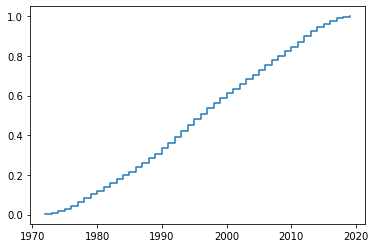

In [69]:
Cdf.from_seq(subset['YEAR_DX']).step()

In [70]:
subset['AGE_DX'].describe()

count    33791.000000
mean        64.991122
std         18.122855
min         -2.000000
25%         54.000000
50%         68.000000
75%         79.000000
max        106.000000
Name: AGE_DX, dtype: float64

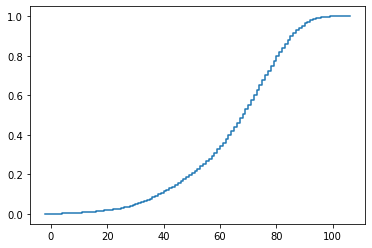

In [71]:
Cdf.from_seq(subset['AGE_DX']).step()

In [72]:
subset['SRV_TIME_MON'].replace(9999, np.nan, inplace=True)

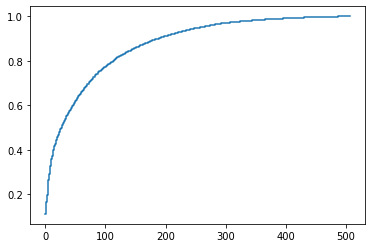

In [73]:
Cdf.from_seq(subset['SRV_TIME_MON']).step()

In [74]:
valid = subset[subset['SRV_TIME_MON'].notna()]
T = valid['SRV_TIME_MON']
E = (valid['STAT_REC'] == 0)

In [75]:
T.describe()

count    32446.000000
mean        64.492418
std         87.435471
min          0.000000
25%          5.000000
50%         27.000000
75%         89.000000
max        506.000000
Name: SRV_TIME_MON, dtype: float64

In [76]:
E.describe()

count     32446
unique        2
top        True
freq      24474
Name: STAT_REC, dtype: object

In [77]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [78]:
kmf.fit(T, E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 32446 total observations, 7972 right-censored observations>

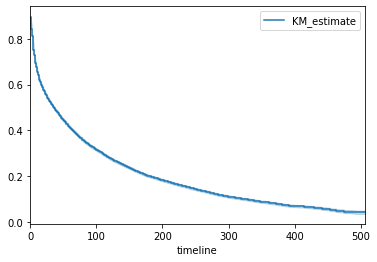

In [79]:
kmf.plot()

In [80]:
def estimate_kaplan_meier(df):

    valid = df[df['SRV_TIME_MON'].notna()]
    T = valid['SRV_TIME_MON']
    E = (valid['STAT_REC'] == 0)

    kmf = KaplanMeierFitter()
    kmf.fit(T, E)

    return kmf


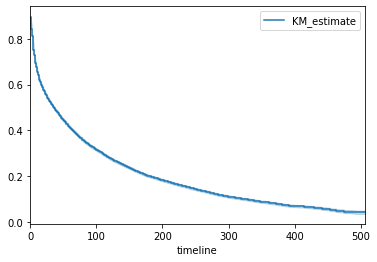

In [81]:
kmf = estimate_kaplan_meier(subset)
kmf.plot()

In [82]:
before = subset[subset['YEAR_DX'] < 2000]
after = subset[subset['YEAR_DX'] >= 2000]

In [83]:
before.shape

(19876, 6)

In [84]:
after.shape

(13915, 6)

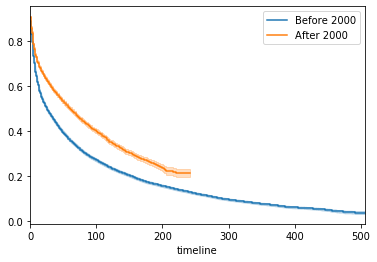

In [85]:
kmf_before = estimate_kaplan_meier(before)
kmf_before.plot(label='Before 2000')

kmf_after = estimate_kaplan_meier(after)
kmf_after.plot(label='After 2000')

In [86]:
from lifelines import CoxPHFitter

data = pd.DataFrame()
data['SRV_TIME_MON'] = subset['SRV_TIME_MON']
data['EVENT'] = (subset['STAT_REC'] == 0)
data['SEX'] = subset['SEX']
data['AGE_DX'] = subset['AGE_DX']
data['YEAR_DX'] = subset['YEAR_DX']

data.dropna(subset=['AGE_DX', 'SRV_TIME_MON'], inplace=True)

cph = CoxPHFitter()
cph.fit(data, duration_col='SRV_TIME_MON', event_col='EVENT')

cph.print_summary()

In [87]:
cph.check_assumptions(data, p_value_threshold=0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'AGE_DX' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'AGE_DX' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'AGE_DX' using pd.cut, and then specify it in
`strata=['AGE_DX', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'YEAR_DX' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'YEAR_DX' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

  

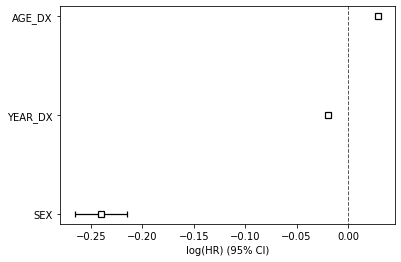

In [88]:
cph.plot()

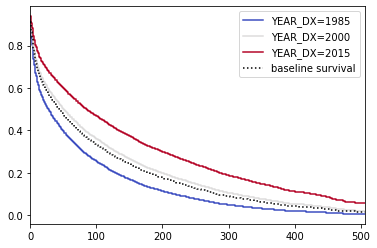

In [89]:
cph.plot_covariate_groups('YEAR_DX', [1985, 2000, 2015], cmap='coolwarm')

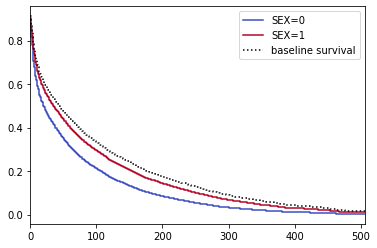

In [90]:
cph.plot_covariate_groups('SEX', [0, 1], cmap='coolwarm')

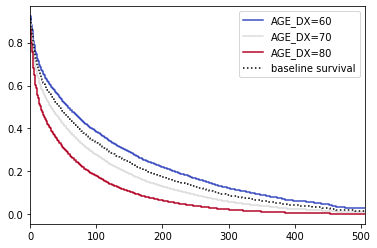

In [91]:
cph.plot_covariate_groups('AGE_DX', [60, 70, 80], cmap='coolwarm')